In [28]:
from langgraph.graph import StateGraph, START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated,Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,SystemMessage

In [29]:
load_dotenv()

True

In [30]:
generator_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
evaluator_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
optimizer_llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [38]:
class TweetState(TypedDict):
    topic : str
    tweet : str
    evaluation : Literal["approved","needs_improvement"]
    feedback : str
    iteration : int
    max_iterations : int 


class TweetEvaluation(BaseModel):
    evaluation : Literal["approved","needs_improvement"] = Field(..., description= "Final Evaluation Result")
    feedback : str = Field(... , description= "Constructive feedback for the tweet")

structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [47]:
def generate_tweet(state:TweetState):

    prompt = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}"
        
        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day-to-day English.
        - This is version {state['iteration'] + 1}.
        """)
    ]

    tweet = generator_llm.invoke("prompt").content
    return {"tweet":tweet}

def evaluate_tweet(state:TweetState):
    
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality - Is this fresh, or have you seen it a hundred times before?
    2. Humor - Did it genuinely make you smile, laugh, or chuckle?
    3. Punchiness - Is it short, sharp, and scroll-stopping?
    4. Virality Potential - Would people retweet or share it?
    5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Don't end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"
    - feedback: One paragraph explaining the strengths and weaknesses
    """)
    ]

    response = structured_evaluator_llm.invoke(messages)

    return {"evaluation":response.evaluation,"feedback":response.feedback }
 
def optimize_tweet(state:TweetState):
      
    messages = [
    SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    "{state['feedback']}"

    Topic: "{state['topic']}"
    Original Tweet:
    {state['tweet']}

    Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
    """)
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] +1

    return {'tweet':response, 'iteration':iteration}

def check_condition(state:TweetEvaluation)-> Literal["approved","needs_improvement"]:
    if state['evaluation'] =="approved" or state['iteration'] >= state['statemax_iterations']:
        return "approved"
    else:
        return "needs_improvement"

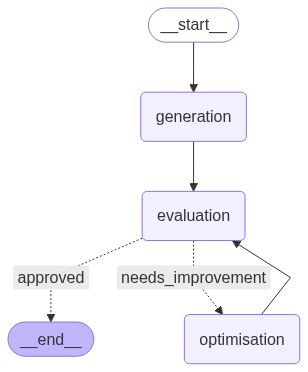

In [48]:
graph = StateGraph(TweetState)

graph.add_node("generation",generate_tweet)
graph.add_node("evaluation",evaluate_tweet)
graph.add_node("optimisation",optimize_tweet)

graph.add_edge(START,"generation")
graph.add_edge("generation","evaluation")
graph.add_conditional_edges("evaluation",check_condition, {"approved":END ,"needs_improvement":"optimisation"})
graph.add_edge("optimisation","evaluation")

workflow= graph.compile()
graph.compile()



In [49]:
initial_state = {"topic":"Indian Railways","iteration":1, "max_iterations":5}

final_state = workflow.invoke(initial_state)
print(final_state)

TypeError: 'TweetEvaluation' object is not subscriptable

In [53]:
initial_state = {"topic":"Indian Railways","iteration":1, "max_iterations":5}
generate_tweet(initial_state)
evaluate_tweet(TweetState)

{'evaluation': 'needs_improvement',
 'feedback': "This tweet is not funny or original. It simply states a Python variable, which has no inherent comedic value or virality potential. The format is acceptable, but the content lacks any engaging element. It's unlikely to be shared or appreciated by a wide audience."}